In [1]:
from CT_COVID_Preprocess import CTCOVIDDataset
from model_tools import validation, train, load_model_checkpoint
from eval_tools import VGG19_CAM
from eval_tools import plot_train_val, test, display_FP_FN, get_confusion_matrix, plot_ROCAUC_curve, showCAM
from custom_model import CNN_COVIDCT
import torch
import torchvision
import torch.optim as optim
from monai.transforms import Compose, LoadPNG, AddChannel, ScaleIntensity, ToTensor, RandRotate, RandFlip, RandZoom, Resize, RandGaussianNoise
import torch.nn.functional as F
import torch.nn as nn
from torch.utils.data import DataLoader
from collections import OrderedDict
from torchvision import transforms

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [3]:
dirCOVID = 'C:/Users/rrsoo/AdvancedStuff/Medical_AI/Classifier/Images-processed-new/CT_COVID'
dirNonCOVID = 'C:/Users/rrsoo/AdvancedStuff/Medical_AI/Classifier/Images-processed-new/CT_NonCOVID'

In [4]:
train_transforms = transforms.Compose([
        LoadPNG(),
        AddChannel(),
        ScaleIntensity(),
        RandRotate(degrees=15, prob=0.5),
        RandFlip(spatial_axis=0, prob=0.5),
        RandZoom(min_zoom=0.9, max_zoom=1.1, prob=0.5),
        RandGaussianNoise(prob = 0.5),
        Resize(spatial_size=(224, 224)),
        ToTensor()
    ])
   

val_transforms = transforms.Compose([
    LoadPNG(),
    AddChannel(),
    ScaleIntensity(),
    ToTensor()
])

In [5]:
BATCH_SIZE = 64
ORIG_RES = False

train_ds = CTCOVIDDataset(dirCOVID, dirNonCOVID, transforms = train_transforms, data = 'train', orig_res = ORIG_RES)
train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)

val_ds = CTCOVIDDataset(dirCOVID, dirNonCOVID, transforms = val_transforms, data = 'val', orig_res = ORIG_RES)
val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=True)

test_ds = CTCOVIDDataset(dirCOVID, dirNonCOVID, transforms = val_transforms, data = 'test', orig_res = ORIG_RES)
test_loader = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=True)

100%|██████████| 346/346 [00:01<00:00, 335.52it/s]


In [6]:
model_name = 'vgg19' #changeable
PRETRAINED = True #changeable

model = None #Don't touch

if model_name == 'vgg19':
    model = torchvision.models.vgg19(pretrained = PRETRAINED).to(device)
    
    if PRETRAINED:
        for param in model.parameters():
            param.requires_grad = False
            
    layers_vgg19 = nn.Sequential(OrderedDict([
            ('fc1', nn.Linear(25088, 512)),
            ('activation1', nn.ReLU()),
            ('dropout1', nn.Dropout()),
            ('fc2', nn.Linear(512, 256)),
            ('activation2', nn.ReLU()),
            ('dropout2', nn.Dropout()),
            ('fc3', nn.Linear(256, 128)),
            ('activation3', nn.ReLU()),
            ('dropout3', nn.Dropout()),
            ('fc4', nn.Linear(128, 2)),
            ('out', nn.Sigmoid())

        ])).to(device)
    model.classifier = layers_vgg19

assert(model is not None)
print(model)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padd

In [7]:
epochs = 40
optimizer = optim.Adam(model.parameters())
#scheduler = optim.lr_scheduler.CyclicLR(optimizer, base_lr=1e-3, max_lr=1e-2, cycle_momentum=False)
criterion = nn.CrossEntropyLoss()
history = train(model, train_loader, val_loader, optimizer, criterion, epochs, device = device, scheduler = None)

  0%|          | 0/10 [00:00<?, ?it/s]

Training Loss: 6.956918478012085
Training Accuracy: 0.5243697478991597
Validation Loss: 1.3880950212478638
Validation Accuracy: 0.5675675675675675


  0%|          | 0/10 [00:00<?, ?it/s]

Training Loss: 6.850770533084869
Training Accuracy: 0.5495798319327732
Validation Loss: 1.3301559686660767
Validation Accuracy: 0.7837837837837838


  0%|          | 0/10 [00:00<?, ?it/s]

Training Loss: 6.9543217420578
Training Accuracy: 0.5462184873949579
Validation Loss: 1.33311527967453
Validation Accuracy: 0.6081081081081081


  0%|          | 0/10 [00:00<?, ?it/s]

Training Loss: 6.606264114379883
Training Accuracy: 0.6
Validation Loss: 1.3072346448898315
Validation Accuracy: 0.5945945945945946


  0%|          | 0/10 [00:00<?, ?it/s]

Training Loss: 6.280668497085571
Training Accuracy: 0.6420168067226891
Validation Loss: 1.1643261909484863
Validation Accuracy: 0.7702702702702703


  0%|          | 0/10 [00:00<?, ?it/s]

Training Loss: 5.720757603645325
Training Accuracy: 0.7445378151260504
Validation Loss: 1.1620736718177795
Validation Accuracy: 0.7837837837837838


  0%|          | 0/10 [00:00<?, ?it/s]

Training Loss: 5.374630898237228
Training Accuracy: 0.7697478991596639
Validation Loss: 1.0119131207466125
Validation Accuracy: 0.8108108108108109


  0%|          | 0/10 [00:00<?, ?it/s]

Training Loss: 5.2720862329006195
Training Accuracy: 0.7899159663865546
Validation Loss: 0.867485761642456
Validation Accuracy: 0.8108108108108109


  0%|          | 0/10 [00:00<?, ?it/s]

Training Loss: 5.05113011598587
Training Accuracy: 0.8
Validation Loss: 1.1000376641750336
Validation Accuracy: 0.8243243243243243


  0%|          | 0/10 [00:00<?, ?it/s]

Training Loss: 4.926339328289032
Training Accuracy: 0.8033613445378152
Validation Loss: 1.1124624609947205
Validation Accuracy: 0.7837837837837838


  0%|          | 0/10 [00:00<?, ?it/s]

Training Loss: 4.866516441106796
Training Accuracy: 0.8100840336134454
Validation Loss: 0.9071873128414154
Validation Accuracy: 0.7972972972972973


  0%|          | 0/10 [00:00<?, ?it/s]

Training Loss: 5.116383671760559
Training Accuracy: 0.8067226890756303
Validation Loss: 0.9016804099082947
Validation Accuracy: 0.8783783783783784


  0%|          | 0/10 [00:00<?, ?it/s]

Training Loss: 4.833878666162491
Training Accuracy: 0.8201680672268907
Validation Loss: 0.9736038744449615
Validation Accuracy: 0.8243243243243243


  0%|          | 0/10 [00:00<?, ?it/s]

Training Loss: 5.107296526432037
Training Accuracy: 0.7966386554621848
Validation Loss: 1.0679120421409607
Validation Accuracy: 0.7567567567567568


  0%|          | 0/10 [00:00<?, ?it/s]

Training Loss: 4.665245413780212
Training Accuracy: 0.8319327731092437
Validation Loss: 1.004795879125595
Validation Accuracy: 0.7972972972972973


  0%|          | 0/10 [00:00<?, ?it/s]

Training Loss: 4.574347943067551
Training Accuracy: 0.8521008403361344
Validation Loss: 0.9386322498321533
Validation Accuracy: 0.8918918918918919


  0%|          | 0/10 [00:00<?, ?it/s]

Training Loss: 4.390781760215759
Training Accuracy: 0.8857142857142857
Validation Loss: 0.8511930406093597
Validation Accuracy: 0.8918918918918919


  0%|          | 0/10 [00:00<?, ?it/s]

Training Loss: 4.187455922365189
Training Accuracy: 0.8974789915966387
Validation Loss: 0.8936146795749664
Validation Accuracy: 0.8378378378378378


  0%|          | 0/10 [00:00<?, ?it/s]

Training Loss: 4.241017580032349
Training Accuracy: 0.8873949579831932
Validation Loss: 0.9021614789962769
Validation Accuracy: 0.8918918918918919


  0%|          | 0/10 [00:00<?, ?it/s]

Training Loss: 4.067489296197891
Training Accuracy: 0.9159663865546218
Validation Loss: 0.750423014163971
Validation Accuracy: 0.9054054054054054


  0%|          | 0/10 [00:00<?, ?it/s]

Training Loss: 3.9669995307922363
Training Accuracy: 0.9294117647058824
Validation Loss: 0.8277592062950134
Validation Accuracy: 0.9054054054054054


  0%|          | 0/10 [00:00<?, ?it/s]

Training Loss: 4.165209203958511
Training Accuracy: 0.8991596638655462
Validation Loss: 1.0085914731025696
Validation Accuracy: 0.8648648648648649


  0%|          | 0/10 [00:00<?, ?it/s]

Training Loss: 4.0745817720890045
Training Accuracy: 0.9025210084033614
Validation Loss: 0.9959210455417633
Validation Accuracy: 0.8918918918918919


  0%|          | 0/10 [00:00<?, ?it/s]

Training Loss: 3.9037370681762695
Training Accuracy: 0.9176470588235294
Validation Loss: 0.9932497441768646
Validation Accuracy: 0.8783783783783784


  0%|          | 0/10 [00:00<?, ?it/s]

Training Loss: 3.8799041509628296
Training Accuracy: 0.9277310924369748
Validation Loss: 0.9020722508430481
Validation Accuracy: 0.9054054054054054


  0%|          | 0/10 [00:00<?, ?it/s]

Training Loss: 3.7238259613513947
Training Accuracy: 0.9378151260504202
Validation Loss: 0.7265488803386688
Validation Accuracy: 0.918918918918919


  0%|          | 0/10 [00:00<?, ?it/s]

Training Loss: 3.8323550522327423
Training Accuracy: 0.9260504201680673
Validation Loss: 0.8226715624332428
Validation Accuracy: 0.918918918918919


  0%|          | 0/10 [00:00<?, ?it/s]

Training Loss: 3.775015950202942
Training Accuracy: 0.934453781512605
Validation Loss: 0.7266824543476105
Validation Accuracy: 0.918918918918919


  0%|          | 0/10 [00:00<?, ?it/s]

Training Loss: 3.7960004210472107
Training Accuracy: 0.9378151260504202
Validation Loss: 0.8751769661903381
Validation Accuracy: 0.8783783783783784


  0%|          | 0/10 [00:00<?, ?it/s]

Training Loss: 3.865012139081955
Training Accuracy: 0.9327731092436975
Validation Loss: 0.922787070274353
Validation Accuracy: 0.9054054054054054


  0%|          | 0/10 [00:00<?, ?it/s]

Training Loss: 3.935752272605896
Training Accuracy: 0.9159663865546218
Validation Loss: 0.8213403224945068
Validation Accuracy: 0.9054054054054054


  0%|          | 0/10 [00:00<?, ?it/s]

Training Loss: 3.616228759288788
Training Accuracy: 0.9546218487394958
Validation Loss: 0.8779657483100891
Validation Accuracy: 0.9054054054054054


  0%|          | 0/10 [00:00<?, ?it/s]

Training Loss: 3.6585539877414703
Training Accuracy: 0.9495798319327731
Validation Loss: 0.832756757736206
Validation Accuracy: 0.8918918918918919


  0%|          | 0/10 [00:00<?, ?it/s]

Training Loss: 3.627478063106537
Training Accuracy: 0.9512605042016806
Validation Loss: 0.7553613781929016
Validation Accuracy: 0.8918918918918919


  0%|          | 0/10 [00:00<?, ?it/s]

Training Loss: 3.6086136400699615
Training Accuracy: 0.9478991596638655
Validation Loss: 0.7169626951217651
Validation Accuracy: 0.9054054054054054


  0%|          | 0/10 [00:00<?, ?it/s]

Training Loss: 3.6767536997795105
Training Accuracy: 0.9495798319327731
Validation Loss: 0.7419536709785461
Validation Accuracy: 0.9324324324324325


  0%|          | 0/10 [00:00<?, ?it/s]

Training Loss: 3.8148661851882935
Training Accuracy: 0.9310924369747899
Validation Loss: 0.7905069589614868
Validation Accuracy: 0.9324324324324325


  0%|          | 0/10 [00:00<?, ?it/s]

Training Loss: 3.7837122082710266
Training Accuracy: 0.9478991596638655
Validation Loss: 0.7762700617313385
Validation Accuracy: 0.918918918918919


  0%|          | 0/10 [00:00<?, ?it/s]

Training Loss: 3.8279646933078766
Training Accuracy: 0.9361344537815126
Validation Loss: 0.8756310641765594
Validation Accuracy: 0.9324324324324325


100%|██████████| 2/2 [00:00<00:00,  2.01it/s]

Training Loss: 3.6855852007865906
Training Accuracy: 0.9529411764705882
Validation Loss: 0.9565800726413727
Validation Accuracy: 0.9054054054054054


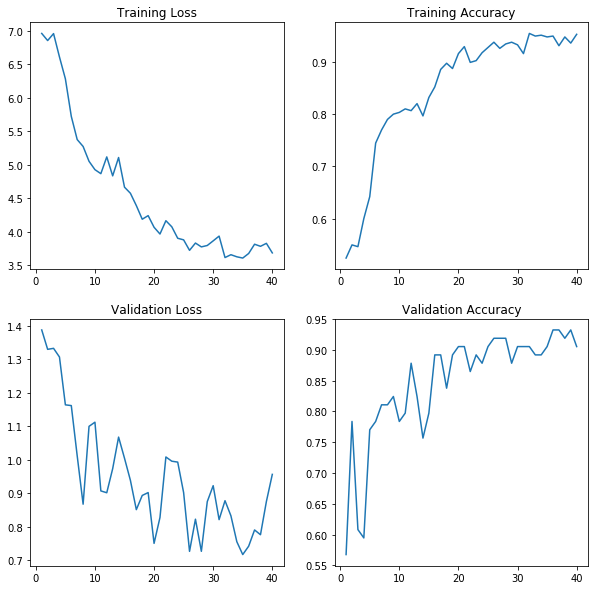

In [8]:
plot_train_val(history, epochs, (10, 10))

In [9]:
'''
model_dir = None

checkpoints = {
    'model' : model,
    'input_shape' : (224, 224, 3),
    'batch_size' : 32,
    'epochs' : 30,
    'train_acc' : 94.5,
    'val_acc' : 97.3,
    'state_dict' : model.state_dict()
}

torch.save(checkpoints, model_dir)
'''

"\nmodel_dir = None\n\ncheckpoints = {\n    'model' : model,\n    'input_shape' : (224, 224, 3),\n    'batch_size' : 32,\n    'epochs' : 30,\n    'train_acc' : 94.5,\n    'val_acc' : 97.3,\n    'state_dict' : model.state_dict()\n}\n\ntorch.save(checkpoints, model_dir)\n"